# 予測ベースのトレードルール

TODO
- ボリンジャーバンドや移動平均線、RSIなどのテクニカル指標を追加

input:現在の日付、所持金、取り扱いデータ（dataframe）<br>
output:更新された所持金<br>

In [5]:
import pandas as pd

import matplotlib.pyplot as plt
import numpy as np

import sys
sys.path.append('C:/Users/masay/Documents/Python Scripts/FX_trade/fx_trade')
from utils.macd import calc_macd,out_cross_flag

In [6]:
#パラメータ
current_day = '2021-06-07'
posses = {'JPY':10000,'USD':0}
jpy_usd = pd.read_csv('../temp_data/jpy_usd.csv')

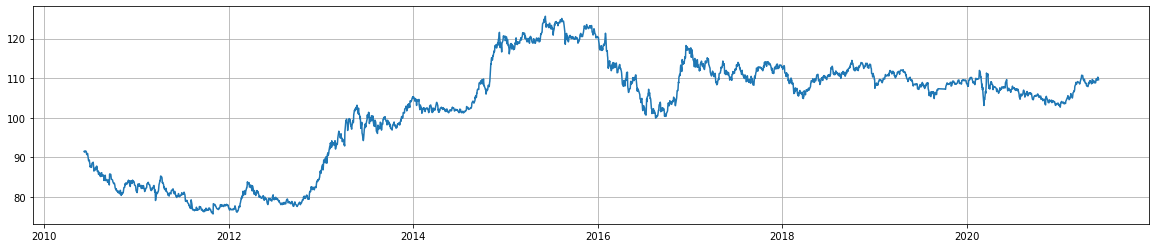

In [7]:
jpy_usd.index = pd.to_datetime(jpy_usd['Date'])
del jpy_usd['Date']
next_day = jpy_usd[current_day:].index[0]
jpy_usd = jpy_usd[:current_day]
plt.figure(figsize=(20,4))
plt.plot(jpy_usd['Close'])
plt.grid()
plt.show()

In [8]:
#次の1日の分行を足しておく
jpy_usd.loc[next_day] = 0

In [12]:
jpy_usd.head()

,Open,High,Low,Close,Adj Close,Volume,macd_flag
Date,,,,,,,
2010-06-07,91.570000,92.064003,90.989998,91.515999,91.515999,0,NaN
2010-06-08,91.489998,91.906998,90.885002,91.410004,91.410004,0,NaN
2010-06-09,91.410004,91.654999,91.040001,91.364998,91.364998,0,NaN
2010-06-10,91.320999,91.441002,90.855003,91.308998,91.308998,0,NaN
2010-06-11,91.331001,91.755997,91.262001,91.620003,91.620003,0,NaN


In [10]:
#MACDの計算
macd,macd_signal = calc_macd(jpy_usd['Close'],short_term=12,long_term=26,signal_term=9)
jpy_usd['macd_flag'] = out_cross_flag(macd,macd_signal)

In [11]:
macd = pd.concat([macd,macd_signal],axis=1)
macd.columns = ['macd','macd_signal']

In [53]:
jpy_usd = pd.concat([jpy_usd,macd],axis=1)
jpy_usd

,Open,High,Low,Close,Adj Close,Volume,macd_flag,macd,macd_signal
Date,,,,,,,,,
2010-06-07,91.570000,92.064003,90.989998,91.515999,91.515999,0,NaN,NaN,NaN
2010-06-08,91.489998,91.906998,90.885002,91.410004,91.410004,0,NaN,NaN,NaN
2010-06-09,91.410004,91.654999,91.040001,91.364998,91.364998,0,NaN,NaN,NaN
2010-06-10,91.320999,91.441002,90.855003,91.308998,91.308998,0,NaN,NaN,NaN
2010-06-11,91.331001,91.755997,91.262001,91.620003,91.620003,0,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...
2021-06-01,109.477997,109.693001,109.333000,109.492996,109.492996,0,0,0.162779,0.104731
2021-06-02,109.483002,109.883003,109.483002,109.492996,109.492996,0,0,0.166693,0.117123
2021-06-03,109.593002,110.309998,109.583000,109.595001,109.595001,0,0,0.175997,0.128898


In [54]:
jpy_usd = jpy_usd.drop(['Adj Close','Volume'],axis=1)

In [55]:
from tqdm import tqdm

col = jpy_usd.columns

for i in tqdm(range(1,20)):
    x = jpy_usd[col].shift(i)
    x.columns = [col+'_shift'+str(i) for col in x.columns]
    jpy_usd = pd.concat([jpy_usd,x],axis=1)

100%|█████████████████████████████████████████████████████████████████████████████████| 19/19 [00:00<00:00, 134.96it/s]


In [56]:
jpy_usd = jpy_usd.drop(col[col!='Close'],axis=1)

In [57]:
close = jpy_usd['Close'].copy()
close

Date
2010-06-07     91.515999
2010-06-08     91.410004
2010-06-09     91.364998
2010-06-10     91.308998
2010-06-11     91.620003
                 ...    
2021-06-01    109.492996
2021-06-02    109.492996
2021-06-03    109.595001
2021-06-04    110.265999
2021-06-07      0.000000
Name: Close, Length: 2846, dtype: float64

In [60]:
jpy_usd[jpy_usd.columns[~jpy_usd.columns.isin([col for col in jpy_usd.columns if 'macd' in col])]] = (jpy_usd[jpy_usd.columns[~jpy_usd.columns.isin([col for col in jpy_usd.columns if 'macd' in col])]].div(jpy_usd['Close_shift1'],axis=0)-1)*100

jpy_usd['Close'] = close

for i in tqdm(range(1,20)):
    x = jpy_usd['Close'].shift(i)
    jpy_usd['Close_raw_shift'+str(i)] = x

jpy_usd = jpy_usd.replace({np.inf:0})

jpy_usd = jpy_usd.iloc[40:,:]

jpy_usd = jpy_usd.replace({'gold':1,'dead':-1})

100%|████████████████████████████████████████████████████████████████████████████████| 19/19 [00:00<00:00, 1073.22it/s]


In [61]:
import lightgbm as lgb
reg = lgb.LGBMRegressor()

about_three_years = 750
about_half_years = 110

train = jpy_usd.iloc[-about_three_years-about_half_years:-about_half_years,:]
test = jpy_usd.iloc[-about_half_years:,:]

reg.fit(train.drop('Close',axis=1),train['Close'])

LGBMRegressor()

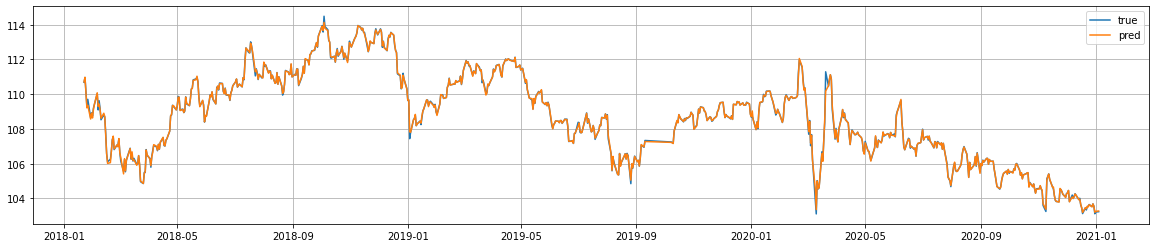

In [62]:
plt.figure(figsize=(20,4))
plt.plot(train.index,train['Close'])
plt.plot(train.index,reg.predict(train.drop('Close',axis=1)))
plt.legend(['true','pred'])
plt.grid()
plt.show()

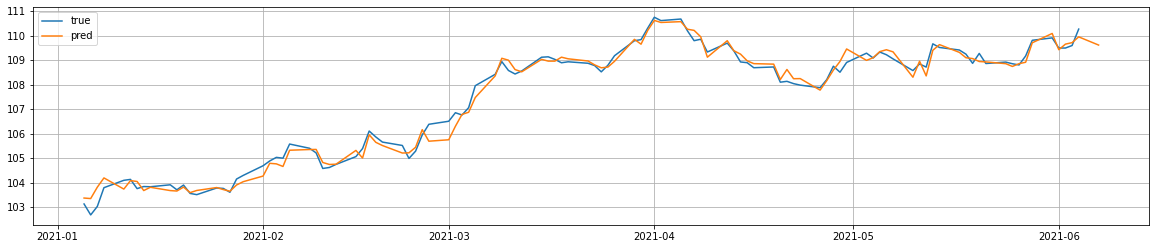

In [63]:
plt.figure(figsize=(20,4))
plt.plot(test.index[:-1],test[:-1]['Close'])
plt.plot(test.index,reg.predict(test.drop('Close',axis=1)))
plt.legend(['true','pred'])
plt.grid()
plt.show()

In [64]:
t = test[:-1]['Close'].diff()
t = t.mask(t>0,1)
t = t.mask(t<0,0)

In [65]:
y = pd.Series(reg.predict(test.drop('Close',axis=1)),index=test.index).diff()
y = y.mask(y>0,1)
y = y.mask(y<0,0)

In [66]:
from sklearn.metrics import confusion_matrix

print(confusion_matrix(t.dropna(),y[:-1].dropna()))

[[37 14]
 [16 41]]


In [72]:
from sklearn.metrics import accuracy_score
print(accuracy_score(t.dropna(),y[:-1].dropna()))

0.7222222222222222


In [67]:
train = jpy_usd.iloc[-about_three_years:-1,:]
pred_data = jpy_usd.iloc[-1,:]
reg.fit(train.drop('Close',axis=1),train['Close'])
pred = reg.predict(pd.DataFrame(pred_data).T.drop('Close',axis=1))

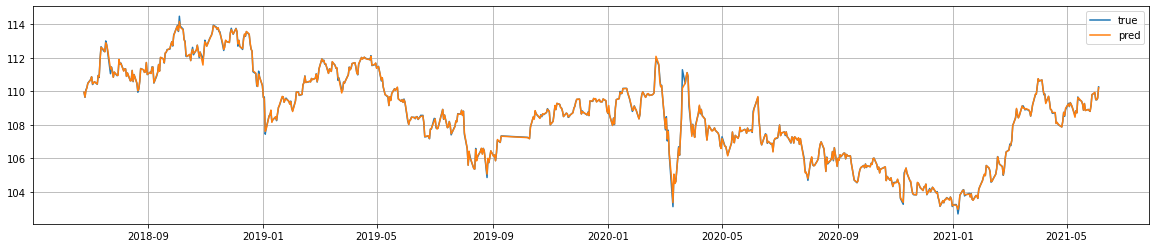

In [68]:
plt.figure(figsize=(20,4))
plt.plot(train.index,train['Close'])
plt.plot(train.index,reg.predict(train.drop('Close',axis=1)))
plt.legend(['true','pred'])
plt.grid()
plt.show()

In [69]:
from sklearn.metrics import mean_absolute_percentage_error

mape = mean_absolute_percentage_error(test[:-1]['Close'],reg.predict(test.drop('Close',axis=1))[:-1])

In [70]:
#直近半年の精度が0.1％以下なら取引する
if mape*100<0.1:
    #今日の引値より明日の予想引値が高いなら買い、逆なら売り
    if test['Close'][-2] < reg.predict(test.drop('Close',axis=1))[-1] and posses['JPY']!=0:
        posses['JPY'] = 0
        posses['USD'] += posses['JPY']/test['Close'][-2]
    elif test['Close'][-2] > reg.predict(test.drop('Close',axis=1))[-1] and posses['USD']!=0:
        posses['USD'] = 0
        posses['JPY'] += posses['USD']*test['Close'][-2]

In [71]:
posses

{'JPY': 10000, 'USD': 0}